In [1]:
from atari_dreamerv3 import Atari
import dreamerv3_wrappers as wrappers

In [2]:
import numpy as np
from post_processing_obs import blackout_obs_mode, crop_obs_mode
from ram_modification_obs import ram_obs_modification_mode
from gymnasium.core import ActionWrapper


class PartialObservationWrapper(wrappers.CutomGymnasiumWrapper):
    """Custom wrapper that modifies observations"""
    
    def __init__(self, env, config):
        super().__init__(env)
        self.config = config

        # Replace the _screen method from Atari env
        self.env._screen = self._screen
    
    def _manipulate_screen(self, array):
        """Modify the screen in buffer"""

        # add a random probability to apply the modification
        if np.random.rand() < self.config['prob']:
            if self.config['type'] == 'blackout':
                blackout_obs_mode(array, self.config['mode'])
            elif self.config['type'] == 'crop':
                crop_obs_mode(array, self.config['mode'])
            elif self.config['type'] == 'ram':
                array = ram_obs_modification_mode(self.env._env, self.config['mode'])
    
    def _screen(self, array):
        self.env._ale.getScreenRGB(array)
        self._manipulate_screen(array)

    # def render(self):
    #     """Override render to show the modified observation"""
    #     if self.render_mode == "rgb_array":
    #         # Get the current observation and apply our modification
    #         obs = self.env.render()
    #         if obs is not None:
    #             return self.observation(obs)
    #     return self.env.render()


class ActionDependentStochasticityWrapper(ActionWrapper):
    """Wrapper that implements action dependent stochasticity in internal ale _env.
    """

    def __init__(self, env, config):
        super().__init__(env)
        self.prob = config['stochastic_action_prob']

    def action(self, action):
        if np.random.random() < self.prob:
            # Choose random action
            return self.env.action_space.sample()
        else:
            # Use predicted action
            return action


class StochasticEnv:
    """
    Environment type docstrings:

    0: Deterministic Env
       - No stochasticity or partial observability applied.

    1: Intrinsic Stochastic Env (action-dependent)
       - Stochasticity is introduced based on the agent's actions.

    2: Intrinsic Stochastic Env (action-independent-random, Aleatoric)
       - Stochasticity is introduced independently of the agent's actions, e.g., random effects. # block not hit, regen

    3: Intrinsic Stochastic Env (action-independent-concept-drift)
       - Stochasticity is introduced by changing environment dynamics over time (concept drift). # within episode and combine sudden and cyclic

    4: Partially observed Env (state-variable-different-repr)
       - The environment state is partially observed by representing state variables differently.

    5: Partially observed Env (state-variable-missing)
       - The environment state is partially observed by omitting some state variables.
    """
    def __init__(self, type, config):
        self.type = type
        self.config = config

    def get_env(self, env):
        if self.type == 0:
            raise NotImplementedError
        elif self.type == 1:
            env._env = ActionDependentStochasticityWrapper(env._env, config=self.config['intrinsic_stochasticity']['action_dependent'])
            return env
        elif self.type == 2:
            raise NotImplementedError
        elif self.type == 3:
            raise NotImplementedError
        elif self.type == 4:
            raise NotImplementedError
        elif self.type == 5:
            return PartialObservationWrapper(env, config=self.config['partial_observation'])

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_frame(obs, label=''):
    """Plot a frame without going into interactive mode"""
    # Create a new figure with non-interactive backend for this plot
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(obs)
    ax.set_title(f'Observation {label}')
    ax.axis('off')
    plt.tight_layout()
    plt.show(block=True)  # Don't block, just display
    plt.close()  # Close the figure to free memory

In [4]:
env = Atari(
            'Breakout',
            4,
            [64, 64],
            gray=False,
            noops=0,
            lives='unused',
            sticky=False,
            actions='needed',
            resize='opencv',
            seed=0,
        )

stochasticity_config = {
    'intrinsic_stochasticity': {
        'action_dependent': {
            'stochastic_action_prob': 0.5,
            },
        'action_independent': {
            'concept_drift': NotImplementedError
        },
    },
    'partial_observation': {
            'type': 'ram', # 'blackout' or 'crop' or 'ram'
            'mode': '2', # mode 1 in ram is buggy
            'prob': 0.75,
    },
}

stochasticity_wrapper = StochasticEnv(type=5, config=stochasticity_config)
env = stochasticity_wrapper.get_env(env)

A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


In [5]:
env = wrappers.OneHotAction(env)
env = wrappers.TimeLimit(env, duration=108000)
env = wrappers.SelectAction(env, key="action")
env = wrappers.UUID(env)

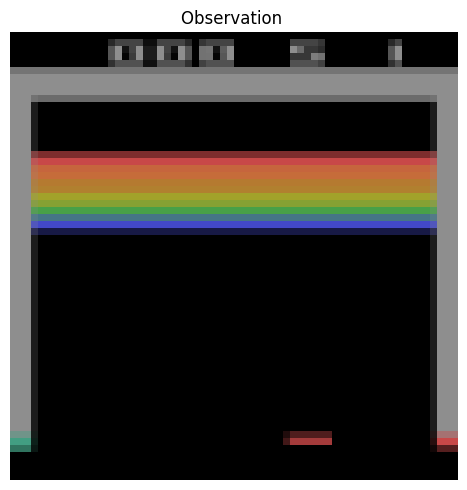

In [6]:
state = env.reset()
state.keys()
plot_frame(state['image'])

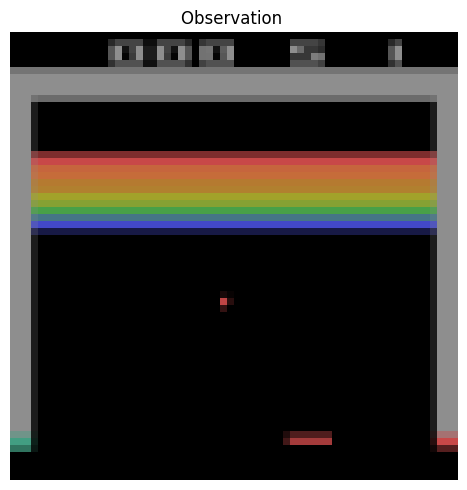

In [7]:
state, reward, is_last, _ = env.step({'action': np.array([0, 1 , 0, 0])})
state.keys()
plot_frame(state['image'])